In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore")

# MyWheels.pl - gears clustering

The goal of this project is predicting on which gear the car is in a given moment for every measurement in the dataset. I've collected this dataset thanks to MyWheels company -> http://mywheels.pl/pl/.

Information that are available to use in the dataset are :
- rpm, 
- speed,
- timestamp of every measurement

Measurements were conducted for 82 different cars on 500 different rides. Overall dataset consists over a 600k measurements.

In [7]:
data = pd.read_csv('rides_bootcamp.csv')
data.head()

,vehicle_id,ride_id,timestamp,type,result
0,1,1,1488353758,rpm,1176
1,1,1,1488353759,rpm,1097
2,1,1,1488353760,rpm,833
3,1,1,1488353764,rpm,1014
4,1,1,1488353767,rpm,907


First step is data preprocessing. Two most important features should be divided into two columns.

In [8]:
rpm = data[data['type']=='rpm'].rename(columns={'result': 'rpm'})
speed = data[data['type']=='speed'].rename(columns={'result': 'speed'})
rpm = rpm.drop('type', axis=1)
speed = speed.drop('type', axis=1)
df = pd.merge(rpm,speed, how='outer', on=['vehicle_id','ride_id','timestamp'])

Next I'm checking null values. There are many of them. I've decided to drop all of them, because filling them with any value (for example mean) would not bring any additional information to future model. I did the same with zero values and I also manually drop some obvious outliers (few observations with speed higher than 250).

In [10]:
df.isnull().sum().sort_values(ascending=False)

speed         114951
rpm            72579
timestamp          0
ride_id            0
vehicle_id         0
dtype: int64

In [11]:
#dropping missing and zero values
df = df[df!=0].dropna()
#outliers removal
df = df[df.speed<250]

Generally in my opinion the moments where RPM have really low values should not be included in the analysis. Points with so low revolutions which are laying on the straight line not necessarily belong to this gear. These points are measured during gear changes and they are creating noise in the data. Because of that I set a threshold equals to 900 and drop all observations for rpm lower than this value.

In [13]:
df = df[df.rpm>900]

# Visualizing the data

First I want to check if there is some correlation for speed or rpm in a time series.

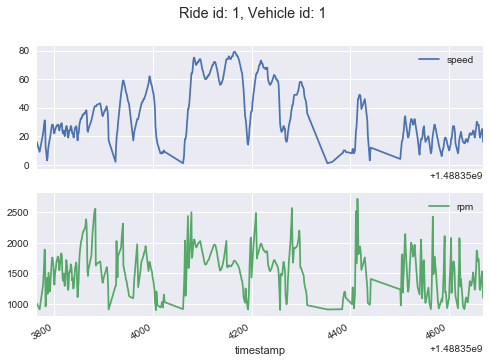

In [15]:
wheels_sample = df[df['ride_id']==1]
wheels_sample.plot(x = 'timestamp', 
                   y=['speed', 'rpm'],
                   subplots=True, 
                   layout=(2,1),
                   title = 'Ride id: {}, Vehicle id: {}'.format(wheels_sample.ride_id.values[0],
                                             wheels_sample.vehicle_id.values[0]))
plt.show()

As we can see for example on a plots above timestamps of measurements are pretty random. I've decided to drop timestamp feature, because I could not see any value which this variable can provide.

This is how data for all of the rides looks like:

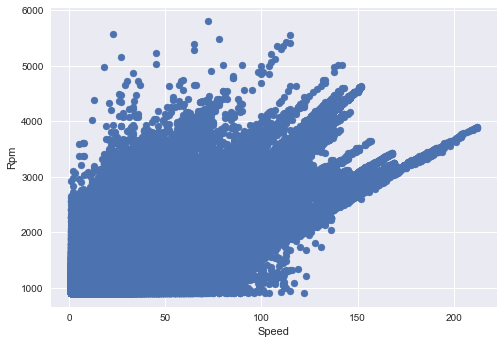

In [16]:
plt.scatter(df.speed, df.rpm)
plt.xlabel('Speed')
plt.ylabel('Rpm')
plt.show()

Visualizing whole dataset is not the best idea because there is so much observations that the graph is unclear. In case of visualising data only for one ride, the obvious pattern could be seen. Speed and rpm are growing lineary, then change of gear happens, rpm is plummeting and linear growth is happening again. We are expecting around 5 or 6 visible clusters for every gear in the car. Of course for every ride number of clusters could be different, because for example sometimes a car could not reach an appropriate speed to change gear to higher value. Let's visualise the speed vs rpm correlation for a few rides.

In [17]:
def visualizing_single_ride(index):
    wheels_sample = df[df['ride_id']==index]
    plt.scatter(wheels_sample.speed, wheels_sample.rpm)
    plt.xlabel('Speed')
    plt.ylabel('Rpm')
    plt.title('Ride id: {}, Vehicle id: {}'.format(wheels_sample.ride_id.values[0],
                                                  wheels_sample.vehicle_id.values[0]))
    plt.show()

In the first graph we can clearly see that 5 gears were used

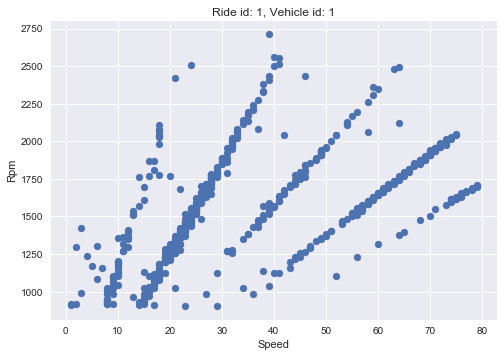

In [18]:
visualizing_single_ride(1)

While in the graph below 4 different clusters could be seen.

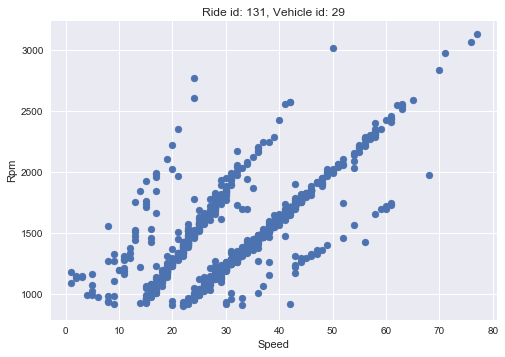

In [19]:
visualizing_single_ride(131)

Here we've got 6:

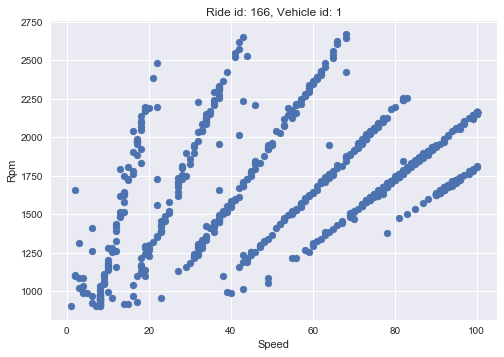

In [20]:
visualizing_single_ride(166)

There are also rides with not so many measurements, where it is hard to guess what is the most appropriate number of clusters.

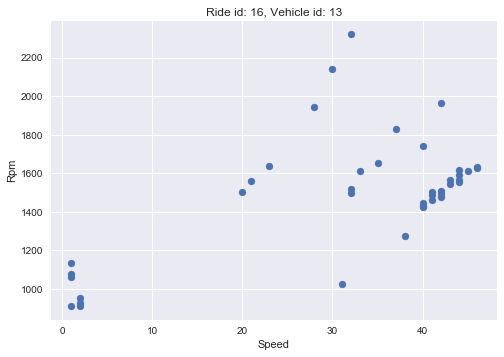

In [21]:
visualizing_single_ride(16)

# Kmeans graphs

Based on conclusion that every ride is different, I've decided to cluster observations separately for every ride. First important problem to solve is choosing the right clustering algorithm for this particular example. As we could see on the graph below without any standarization/normalization kmeans agorithm is not doing a great job, so does Hierarchical clustering or DBScan. This is not our aim to cluster data points in such a way.

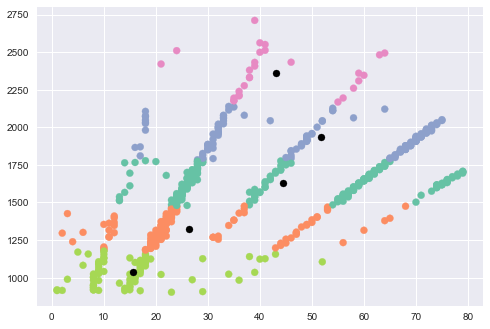

In [22]:
colors = np.array(sns.color_palette("Set2", 20))

def clusters_kmeans(index, n_clusters):
    wheels_sample = df[df['ride_id']==index][['rpm','speed']]
    model = KMeans(n_clusters = n_clusters, random_state=1)
    model.fit(wheels_sample)
    labels = model.predict(wheels_sample)
    plt.scatter(wheels_sample.speed,wheels_sample.rpm,c=colors[labels])
    plt.scatter(model.cluster_centers_[:,1],model.cluster_centers_[:,0], color = 'k')
    plt.show()
clusters_kmeans(index=1, n_clusters=5)

One of the solutions could be creating new feature, which would be a division of speed and rpm. But what is working really well is changing the represantation of the data such as we implement kmeans on cosine distances of the data points. Cosine distance is equal to 1 minus cosinus similarity, which computes similarity as the normalized dot product of X and Y: K(X, Y) = <X, Y> / (||X||*||Y||)

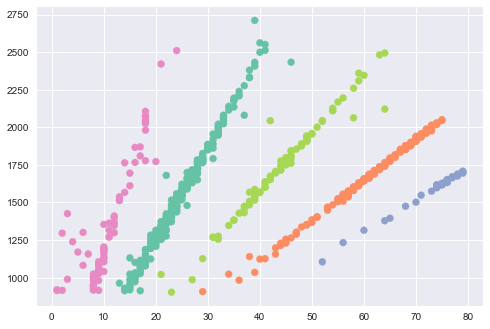

In [23]:
def plot_clusters_cosine(index, n_clusters):
    wheels_sample = df[df['ride_id']==index][['rpm','speed']]
    distance = pairwise_distances(wheels_sample, metric='cosine')
    model = KMeans(n_clusters = n_clusters, random_state=1)
    model.fit(distance)
    labels = model.predict(distance)
    plt.scatter(wheels_sample.speed,wheels_sample.rpm,c=colors[labels])
    plt.show()
clusters_cosine(index=1, n_clusters=5)

As we can see cosine distance as an input to KMeans could be a right approach for detecting pattern in this data.

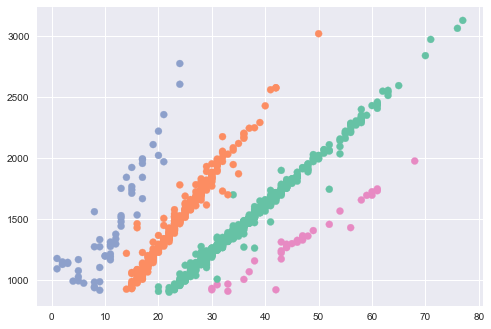

In [24]:
plot_clusters_cosine(index=131, n_clusters=4)

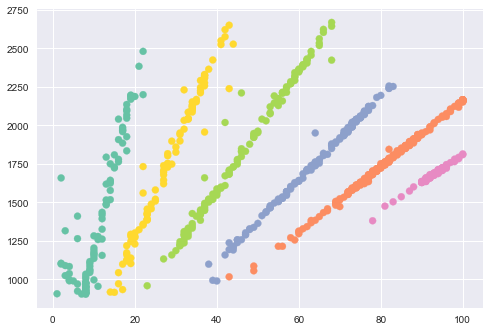

In [25]:
plot_clusters_cosine(index=166, n_clusters=6)

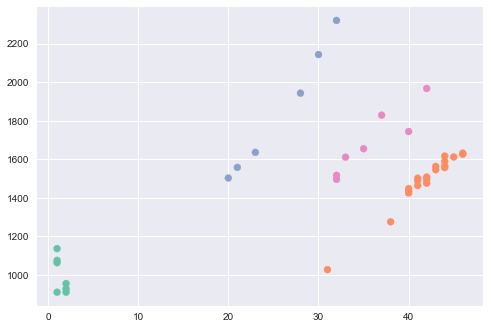

In [28]:
plot_clusters_cosine(index=16, n_clusters=4)

# Choosing the number of clusters

In the scatter plots above I was defining the number of clusters manually. Of course I wouldn't be doing it for every single ride. So next issue is choosing the optimal number of clusters automatically. The answer here is not obvious. As I was manually observing the data, dominant number of clusters are 4-5, but also in some cases 6 is the best choice. I wanted to try using silhouette score to measure optimal cluster number. This metric assuming that the optimal number of clusters is the one that reaches the highest value of silhouette score. Unfortunately in my case for almost every ride it chooses the biggest available number of clusters, which is usually not correct. This is how it looks like for rides that I chose previously: 

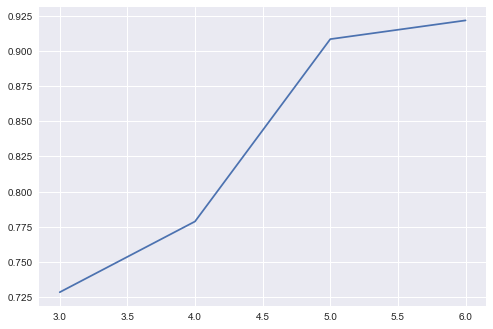

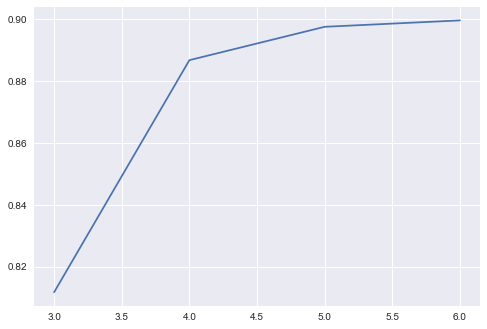

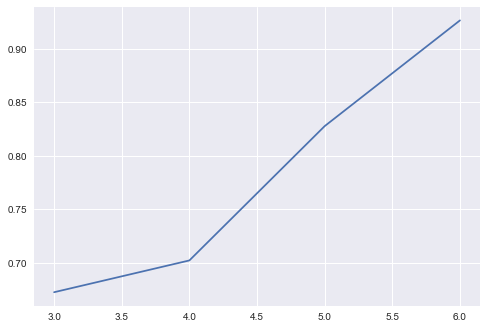

In [76]:
def plot_silhouette_score(index):
    sample = df[df['ride_id']==index][['rpm','speed']]
    ks = range(3,7)
    sil = []
    distance = pairwise_distances(sample, metric='cosine')
    for k in ks:
        model = KMeans(n_clusters = k)
        model.fit(distance)
        sil.append(silhouette_score(distance, model.labels_))
    plt.plot(range(3,7),sil)
    plt.show()  
plot_silhouette_score(index=1)
plot_silhouette_score(index=131)
plot_silhouette_score(index=166)

I have to change this metric a little to get more optimal results. I noticed that what is working much better in most cases is choosing the number of clusters before which there was the biggest improvement in silhouette score, so I chose this metric to evaluate the number of clusters.

In [82]:
def define_clusters_number(index):
    sample = df[df['ride_id']==index][['rpm','speed']]
    distance = pairwise_distances(sample, metric='cosine')
    ks = range(3,7)
    sil = []
    for k in ks:
        model = KMeans(n_clusters = k)
        model.fit(distance)
        sil.append(silhouette_score(distance, model.labels_))
    sil_score = []
    sil_val = [4,5,6]
    for a in zip(sil,sil[1:]):
        sil_score.append((a[0]-a[1])/a[1])
    return sil_val[sil_score.index(min(sil_score))]

print('Optimal number of clusters for ride_id: 1 is {}'.format(define_clusters_number(index=1)))
print('Optimal number of clusters for ride_id: 131 is {}'.format(define_clusters_number(index=131)))
print('Optimal number of clusters for ride_id: 166 is {}'.format(define_clusters_number(index=166)))

Optimal number of clusters for ride_id: 1 is 5
Optimal number of clusters for ride_id: 131 is 4
Optimal number of clusters for ride_id: 166 is 5
Optimal number of clusters for ride_id: 4 is 6


This predefined function for choosing the best number of clusters is definitely not ideal. Algorithm optimizes number of clusters for some of the rides correctly...

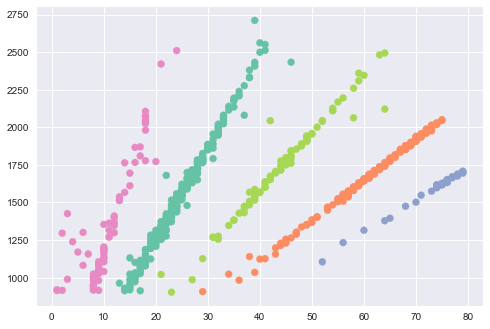

In [97]:
plot_clusters_cosine(index=1, n_clusters=define_clusters_number(index=1))

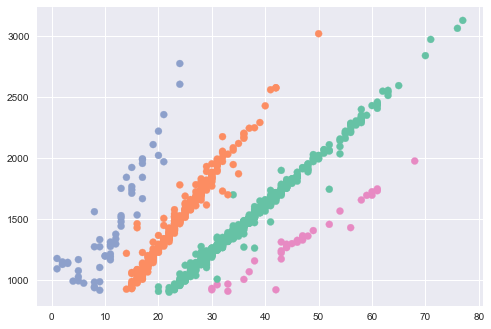

In [99]:
plot_clusters_cosine(index=131, n_clusters=define_clusters_number(index=131))

... but it also fails in some cases such as one below

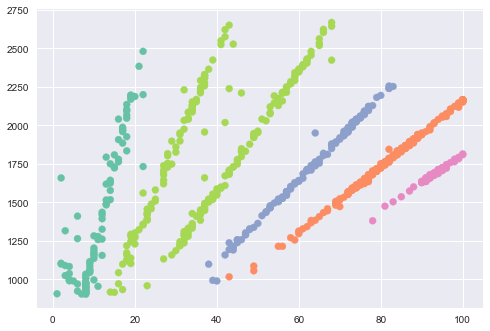

In [100]:
plot_clusters_cosine(index=166, n_clusters=define_clusters_number(index=166))

# Same cluster labels for every ride

The next problem which is ocurring is that algorithm is choosing every label for clusters randomly. So for every ride we get different labeling. For example for one ride label "0" could mean first gear and for another it could be third or fourth gear. What I should do is unifying the direction of choice of the clusters. The solution to this problem is getting the mean of speed/rpm ratio for every cluster, sorting them and mapping the indexes.

In [105]:
def unify_labels(fitted, labels):
    fitted_temp=fitted
    fitted_temp['cluster']=labels
    fitted_temp['norm'] = fitted_temp['speed']/fitted_temp['rpm']               # creating new column speed/rpm
    clusters = pd.DataFrame(fitted_temp.groupby('cluster')['norm'].mean())      # getting mean speed/rpm for every cluster
    cl = clusters.sort_values('norm').reset_index()                             # sorting these values
    cl = dict(zip(cl.norm, cl.index))
    clusters['norm'] = clusters['norm'].map(cl)
    mydict = dict(zip(clusters.index, clusters.values))
    fitted['cluster'].replace(mydict, inplace=True)                             # using mapping and dicts to get indexes and change cluster labels with sorted values 
    fitted.drop('norm',axis=1, inplace=True)

Now I can visualize gears clustering on rides that I was analyzing previously on one plot

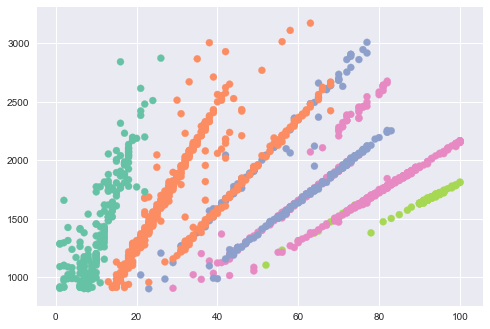

In [111]:
def plot_gear_clustering(index):
    sample = df[df['ride_id']==index][['rpm','speed']]
    distance = pairwise_distances(sample, metric='cosine')
    model = KMeans(n_clusters = define_clusters_number(index), random_state=1)
    model.fit(distance)
    labels = model.predict(distance)  
    unify_labels(sample, labels)                        
    plt.scatter(sample['speed'],sample['rpm'],c=colors[sample.cluster.values])
    
for i in [1,133,166]:
    plot_gear_clustering(i)
plt.show()

As it could be seen even on this small sample of rides, plots for every car could look completely different.

In [94]:
result = pd.DataFrame()
for index in range(1,len(df.ride_id.unique())+1):
    sample = df[df['ride_id']==index][['rpm','speed']]
    distance = pairwise_distances(sample, metric='cosine')
    model = KMeans(n_clusters = define_clusters_number(index), random_state=1)
    model.fit(distance)
    labels = model.predict(distance)  
    unify_labels(sample)                        
    result = pd.concat([result,sample])
df['gear'] = result.cluster
df['gear'] = df['gear'].map(lambda x: x+1)
df.head()

,vehicle_id,ride_id,timestamp,rpm,speed,gear
3,1,1,1488353764,1014.0,16.0,2.0
5,1,1,1488353770,915.0,9.0,1.0
8,1,1,1488353777,1317.0,22.0,2.0
9,1,1,1488353779,1651.0,28.0,2.0
10,1,1,1488353780,1889.0,31.0,2.0


# Final words

The solution is having sense and it is providing educational value. It shows that even pretty simple algorithm such as KMeans  could be effectively used for not so obvious problem. Data that I analyzed in this project created pretty original pattern, which  at first glance was not applicable to use KMeans model. However after some transformations it turned out that this clustering method fits greatly to this kind of problem.